# 2.0 Preprocessing Text 

In [1]:
# lib
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import emoji

import textstat
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


**User def used in this notebook as shown below**

In [2]:
# user def to convert from Json to pd dataframe
# perform cleaning of the dataframe 
def set_up_df(file_jsonl):
    
    # Read the .jsonl file into a DataFrame
    df = pd.read_json(file_jsonl, lines=True)

    # Extracting features of interest
    columns_of_interest = ['selftext','is_self', 'Subreddit','title']# 'comment'
    df = df[columns_of_interest]

    # Filter off rows where 'is_self' only contains URL
    df = df[df['is_self'] == True]
    
    # drop-off 'is_self' column
    df = df.drop(columns = 'is_self')

    # just add this in and rename the merge column called
    
    df['raw_content'] = df['selftext'] + df['title']
    
    # changing the labelcolumn to number
    label_map = {'Amd':1, 'nvidia':0}
    df['num_label'] = df['Subreddit'].map(label_map)
    
    # check for empty raw_content
    df['raw_content'].replace('', pd.NA, inplace=True)
    df.dropna(inplace=True)
    
    # raw_content word count / raw_content lenght / avg word lenght
    df['raw_w_count'] = df['raw_content'].apply(lambda x:len(x.split()))
    df['raw_content_length'] = [len(s) for s in df['raw_content']]
    df['raw_avg_w_length'] = df['raw_content_length'] / df['raw_w_count']
    
    # Readability score
    # lower score means it is suitable for general public (5 or 6)
    # mid score means it is for adult audience (8 to 10)
    # high score means it is for specialized audiences (12 or more)
    df['fk_grade'] = df['raw_content'].apply(textstat.flesch_kincaid_grade)
    df['gunning_fog'] = df['raw_content'].apply(textstat.gunning_fog)
    df['coleman_liau'] = df['raw_content'].apply(textstat.coleman_liau_index)
    
    # Initialize the VADER sentiment intensity analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # Apply VADER to the 'text' column and store the compound score
    df['sentiment'] = df['raw_content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
                                                
    # Return back the dataframe
    return df

# Download required resources
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

def preprocess_text_nltk(text):
    
    # 1. Remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # 2. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # 3. Convert the entire text to lowercase
    text = text.lower()
    
    # 4. Remove dollar signs, newline characters, quotes (both single and double), and question marks
    text = re.sub(r'[\$\n"\'?]', ' ', text)
    
    # 5. Tokenize the text using NLTK
    tokens = word_tokenize(text)
    
    # 6. Lemmatize, remove stop words, punctuation, and filter based on length
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalnum() and 2 <= len(token) <= 15]

    return ' '.join(filtered_tokens)
    

# Cvec show top 10 n_gram function 
def plt_top_ngrams_cvec(subreddit, top_n=10):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    ngram_ranges = [(1,1),(2,2),(3,3)]
    
    for ax, ngram_range in zip(axes, ngram_ranges):
        vectorizer = CountVectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(subreddit)
        feature_names = np.array(vectorizer.get_feature_names_out())
        
        # sum the counts of each feature
        summed = X.sum(axis=0).A1
        
        # Get top_n indices
        indices = summed.argsort()[-top_n:][::-1]

        # Plot
        ax.barh(feature_names[indices], summed[indices])
        ax.set_title(f"Top {top_n} {ngram_range[1]}-grams")
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
# tvec show top 10 n_gram function 
def plt_top_ngrams_tvec(subreddit, top_n=10):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    ngram_ranges = [(1,1),(2,2),(3,3)]
    
    for ax, ngram_range in zip(axes, ngram_ranges):
        vectorizer = TfidfVectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(subreddit)
        feature_names = np.array(vectorizer.get_feature_names_out())
        
        # sum the counts of each feature
        summed = X.sum(axis=0).A1
        
        # Get top_n indices
        indices = summed.argsort()[-top_n:][::-1]

        # Plot
        ax.barh(feature_names[indices], summed[indices])
        ax.set_title(f"Top {top_n} {ngram_range[1]}-grams")
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
def subplot_hist(df, columns, subreddit_col, nrows, ncols, bins):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

    subreddits = df[subreddit_col].unique()
    
    for ax, column in zip(axes.flatten(), columns):
        for subreddit in subreddits:
            subset = df[df[subreddit_col] == subreddit]
            ax.hist(subset[column], bins=bins, alpha=0.7, label=subreddit)
        ax.set_title(column)
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

### 2.1.0 Converting from Json to pandas dataframe for Nvidia

In [ ]:
nvidia_df = set_up_df('nvidia_posts.jsonl')

In [ ]:
nvidia_df.to_csv('nvidia_df_preprocess', index=False)

In [3]:
nvidia_df = pd.read_csv('nvidia_df_preprocess.csv')

In [4]:
nvidia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23815 entries, 0 to 23814
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   raw_content         23815 non-null  object 
 1   raw_w_count         23815 non-null  int64  
 2   raw_content_length  23815 non-null  int64  
 3   raw_avg_w_length    23815 non-null  float64
 4   fk_grade            23815 non-null  float64
 5   gunning_fog         23815 non-null  float64
 6   coleman_liau        23815 non-null  float64
 7   sentiment           23815 non-null  float64
 8   num_label           23815 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 1.6+ MB


#### 2.1.1 Preprocessing text for Nvidia dataframe

Preprocssing of text as the steps shown below 
- Removing URLS, emoji, dollar signs, newline characters. 
- Converting text to lower characters. 
- Using NLTK to perform stopwords removal and lemmatization

Perform word count and lenght of content count after preprocessing.  


In [5]:
# converting raw_content to clean_content using the NLTK-based function
nvidia_df['clean_content'] = nvidia_df['raw_content'].apply(preprocess_text_nltk)

# dropping off empty row clean_content
nvidia_df['clean_content'] = nvidia_df['clean_content'].str.strip()
nvidia_df['clean_content'].replace('', pd.NA, inplace=True)
nvidia_df.dropna(inplace=True)

# clean_content word count
nvidia_df['clean_w_count'] = nvidia_df['clean_content'].apply(lambda x: len(x.split()))

# clean_content length
nvidia_df['clean_content_length'] = nvidia_df['clean_content'].apply(lambda x: sum(len(word) for word in x.split()))


In [6]:
nvidia_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23703 entries, 0 to 23814
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   raw_content           23703 non-null  object 
 1   raw_w_count           23703 non-null  int64  
 2   raw_content_length    23703 non-null  int64  
 3   raw_avg_w_length      23703 non-null  float64
 4   fk_grade              23703 non-null  float64
 5   gunning_fog           23703 non-null  float64
 6   coleman_liau          23703 non-null  float64
 7   sentiment             23703 non-null  float64
 8   num_label             23703 non-null  int64  
 9   clean_content         23703 non-null  object 
 10  clean_w_count         23703 non-null  int64  
 11  clean_content_length  23703 non-null  int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 2.4+ MB


#### Ensure no null value for all the rows in nvidia dataframe

In [7]:
nvidia_df.isnull().sum()

raw_content             0
raw_w_count             0
raw_content_length      0
raw_avg_w_length        0
fk_grade                0
gunning_fog             0
coleman_liau            0
sentiment               0
num_label               0
clean_content           0
clean_w_count           0
clean_content_length    0
dtype: int64

In [8]:
nvidia_df['Subreddit'] = 'nvidia'

nvidia_df.head(3)

,raw_content,raw_w_count,raw_content_length,raw_avg_w_length,fk_grade,gunning_fog,coleman_liau,sentiment,num_label,clean_content,clean_w_count,clean_content_length,Subreddit
0,"What Gpu?""My son wants to upgrade his GPU to p...",72,381,5.291667,5.6,8.31,6.61,0.9054,0,gpu son want upgrade gpu play game faster fram...,35,175,nvidia
1,Which graphics card is better and why? (2080 3060,9,49,5.444444,2.1,3.60,6.06,0.4404,0,graphic card better 2080 3060,5,25,nvidia
2,The price range I am looking to spend is $300-...,20,102,5.100000,7.6,10.00,5.92,0.0000,0,price range looking spend 500 causing deciding...,8,44,nvidia


#### Saving Nvidia content to a CSV file

In [10]:
nvidia_df.to_csv('nvidia_df_clean.csv', index=False)

In [11]:
nvidia_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23703 entries, 0 to 23814
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   raw_content           23703 non-null  object 
 1   raw_w_count           23703 non-null  int64  
 2   raw_content_length    23703 non-null  int64  
 3   raw_avg_w_length      23703 non-null  float64
 4   fk_grade              23703 non-null  float64
 5   gunning_fog           23703 non-null  float64
 6   coleman_liau          23703 non-null  float64
 7   sentiment             23703 non-null  float64
 8   num_label             23703 non-null  int64  
 9   clean_content         23703 non-null  object 
 10  clean_w_count         23703 non-null  int64  
 11  clean_content_length  23703 non-null  int64  
 12  Subreddit             23703 non-null  object 
dtypes: float64(5), int64(5), object(3)
memory usage: 2.5+ MB


### 2.2.0 Converting from Json to pandas dataframe for Amd

In [12]:
# converting from json to dataframe
amd_df = set_up_df('amd_posts.jsonl')

In [13]:
amd_df.to_csv('amd_df_preprocess', index=False)

In [12]:
amd_df = pd.read_csv('amd_df_preprocess.csv')

In [13]:
amd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35711 entries, 0 to 35710
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   raw_content         35711 non-null  object 
 1   raw_w_count         35711 non-null  int64  
 2   raw_content_length  35711 non-null  int64  
 3   raw_avg_w_length    35711 non-null  float64
 4   fk_grade            35711 non-null  float64
 5   gunning_fog         35711 non-null  float64
 6   coleman_liau        35711 non-null  float64
 7   sentiment           35711 non-null  float64
 8   num_label           35711 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 2.5+ MB


#### 2.2.1 Preprocessing text for Amd dataframe

Preprocssing of text as the steps shown below 
- Removing URLS, emoji, dollar signs, newline characters. 
- Converting text to lower characters. 
- Using NLTK to perform stopwords removal and lemmatization


In [14]:
# converting raw_content to clean_content using the NLTK-based function
amd_df['clean_content'] = amd_df['raw_content'].apply(preprocess_text_nltk)

# dropping off empty row clean_content
amd_df['clean_content'] = amd_df['clean_content'].str.strip()
amd_df['clean_content'].replace('', pd.NA, inplace=True)
amd_df.dropna(inplace=True)

# clean_content word count
amd_df['clean_w_count'] = amd_df['clean_content'].apply(lambda x: len(x.split()))

# clean_content length
amd_df['clean_content_length'] = amd_df['clean_content'].apply(lambda x: sum(len(word) for word in x.split()))

In [15]:
amd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35585 entries, 0 to 35710
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   raw_content           35585 non-null  object 
 1   raw_w_count           35585 non-null  int64  
 2   raw_content_length    35585 non-null  int64  
 3   raw_avg_w_length      35585 non-null  float64
 4   fk_grade              35585 non-null  float64
 5   gunning_fog           35585 non-null  float64
 6   coleman_liau          35585 non-null  float64
 7   sentiment             35585 non-null  float64
 8   num_label             35585 non-null  int64  
 9   clean_content         35585 non-null  object 
 10  clean_w_count         35585 non-null  int64  
 11  clean_content_length  35585 non-null  int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 3.5+ MB


#### Ensure no null value for all the rows in Amd dataframe

In [16]:
amd_df.isnull().sum()

raw_content             0
raw_w_count             0
raw_content_length      0
raw_avg_w_length        0
fk_grade                0
gunning_fog             0
coleman_liau            0
sentiment               0
num_label               0
clean_content           0
clean_w_count           0
clean_content_length    0
dtype: int64

In [18]:
amd_df['Subreddit'] = 'amd'

amd_df.head(3)

,raw_content,raw_w_count,raw_content_length,raw_avg_w_length,fk_grade,gunning_fog,coleman_liau,sentiment,num_label,clean_content,clean_w_count,clean_content_length,Subreddit
0,"HYPR-RX and RDNA 1-2""Gotta say I'm kinda bumme...",18,86,4.777778,6.8,7.2,3.36,0.0,1,rdna got ta say kinda bummed see come rdna,9,34,amd
1,"Cheers.""""At least for now",4,25,6.250000,1.3,1.6,4.35,0.0,1,cheer least,2,10,amd
2,>Club386: Why have you in the first instance,8,44,5.500000,0.5,3.2,5.76,0.0,1,club386 first instance,3,20,amd


#### Saving Amd content to a CSV file

In [19]:
amd_df.to_csv('amd_df_clean.csv', index=False)

### 2.3.0 Combining Amd and Nvidia into one dataframe 


In [20]:
clean_df = pd.concat([nvidia_df, amd_df], axis=0)

In [21]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59288 entries, 0 to 35710
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   raw_content           59288 non-null  object 
 1   raw_w_count           59288 non-null  int64  
 2   raw_content_length    59288 non-null  int64  
 3   raw_avg_w_length      59288 non-null  float64
 4   fk_grade              59288 non-null  float64
 5   gunning_fog           59288 non-null  float64
 6   coleman_liau          59288 non-null  float64
 7   sentiment             59288 non-null  float64
 8   num_label             59288 non-null  int64  
 9   clean_content         59288 non-null  object 
 10  clean_w_count         59288 non-null  int64  
 11  clean_content_length  59288 non-null  int64  
 12  Subreddit             59288 non-null  object 
dtypes: float64(5), int64(5), object(3)
memory usage: 6.3+ MB


In [22]:
clean_df.isnull().sum()

raw_content             0
raw_w_count             0
raw_content_length      0
raw_avg_w_length        0
fk_grade                0
gunning_fog             0
coleman_liau            0
sentiment               0
num_label               0
clean_content           0
clean_w_count           0
clean_content_length    0
Subreddit               0
dtype: int64

#### Saving content to a CSV file

In [23]:
clean_df.to_csv('clean_df_merge.csv', index=False)

---
# 3.0 Exploratory data analysis 

### 3.1.0 Nvidia and Amd Class  

Seem like it the class is imbalance, going to deal with it the modeling stage. 

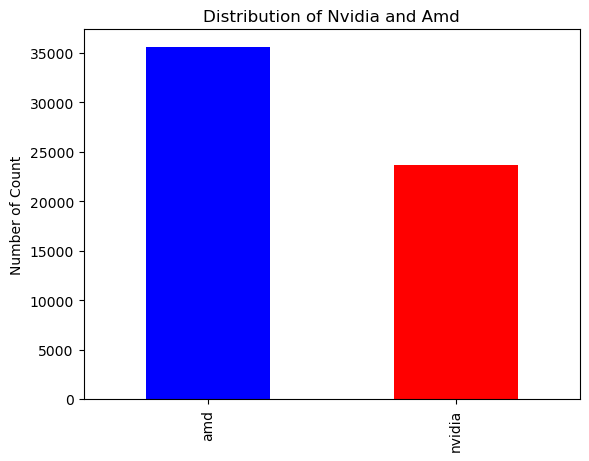

In [24]:
# count the occurrences of each value
value_counts = clean_df['Subreddit'].value_counts()

# Plot 
value_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Nvidia and Amd')
plt.ylabel('Number of Count')
plt.show()

### 3.2.0 Sentiment analysis compound Score  for both Nvidia and Amd

**VADER**

The polarity_scores method returns a dictionary with four scores:

- compound: A single number that denotes the sentiment of the text. Ranges from -1 (most negative) to 1 (most positive).
- pos: Proportion of the text that is positive.
- neu: Proportion of the text that is neutral.
- neg: Proportion of the text that is negative

For this project, we are using compound score, due to it is easier to compute and compare.  


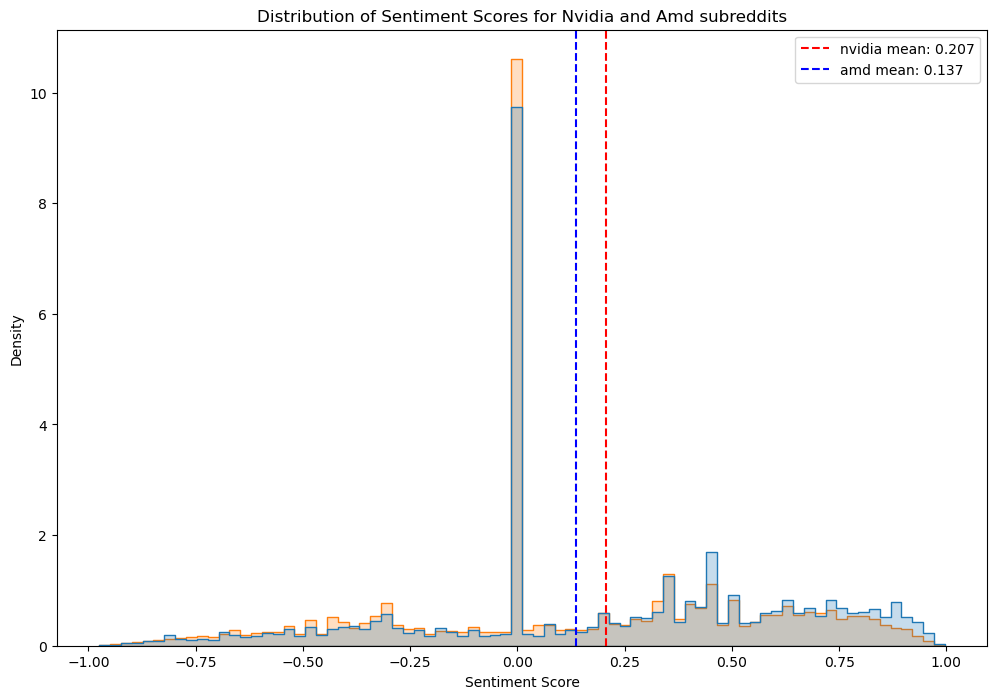

In [25]:
plt.figure(figsize=(12,8))

sns.histplot(data=clean_df, x='sentiment', hue='Subreddit', element='step', 
             stat='density', common_norm=False)

# calculate mean values for each Subreddit
subreddits = clean_df['Subreddit'].unique()
for subreddit in subreddits:
    mean_value = clean_df[clean_df['Subreddit'] == subreddit]['sentiment'].mean()
    round_mean = round(mean_value,3)
    plt.axvline(round_mean, color='red' if subreddit == 'nvidia' else 'blue',
               linestyle='--', label=f"{subreddit} mean: {round_mean}" )

plt.title('Distribution of Sentiment Scores for Nvidia and Amd subreddits')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

#### 3.2.1 Sentiment analysis observation
 
- Neutral sentiment: Both Subreddits have a peak around the neutral sentiment score (close to 0), this indicates that a significant portion of the posts in both subreddits have a neutral sentiment. 

- Positive Sentiment: Both subreddits have a good number of posts with positive sentiment scores (greater than 0).But nvidia subreddit seems to have a slightly higher positive sentiment score count. 

- Negative Sentiment: Both subreddit also have posts with negative sentiment scores (less than 0). The distribution appears to be fairlly similar for both subreddit in the negative sentiment range. But Amd seem to have a slightly higher negative sentiment score count.  

- Sentiment mean value score: For Nvidia, the 0.207, while Amd was 0.137. This shows that Amd post generally were more negative as compare to Nvidia

### 3.3.0 Readability score for Amd and Nvidia 

link:https://textstat.readthedocs.io/en/latest/#

Grade Level Interpretation (Flesch-Kincaid Grade):

- A score of 8.0 means that an eighth grader (typically around 13-14 years old) would be expected to understand the text.
- A score of 12.0 suggests that a high school senior (typically around 17-18 years old) would be expected to understand the text.
- Scores above 12.0 indicate college-level or higher reading complexity.

Contextualizing the Scores (Index):

- Lower Scores: Texts with lower scores (e.g., 5.0 or 6.0) are simpler and should be more broadly accessible to a general audience. These might be suitable for general public announcements or basic informational materials.

- Medium Scores: Texts with medium scores (e.g., 8.0 to 10.0) have a moderate level of complexity. They might be suitable for a general adult audience but could be challenging for younger readers.

- Higher Scores: Texts with higher scores (e.g., 12.0 and above) are more complex. They might be suitable for specialized audiences, such as professionals or academics in a particular field.

- Not a Measure of Quality: It's essential to understand that a higher or lower readability score doesn't necessarily indicate the quality or value of the text. A high score doesn't mean the content is "better" or more valuable – it simply means it's more complex. Similarly, a low score doesn't mean the content is "worse" or less valuable – it just means it's more accessible.

In [26]:
print(clean_df['Subreddit'].value_counts())

amd       35585
nvidia    23703
Name: Subreddit, dtype: int64


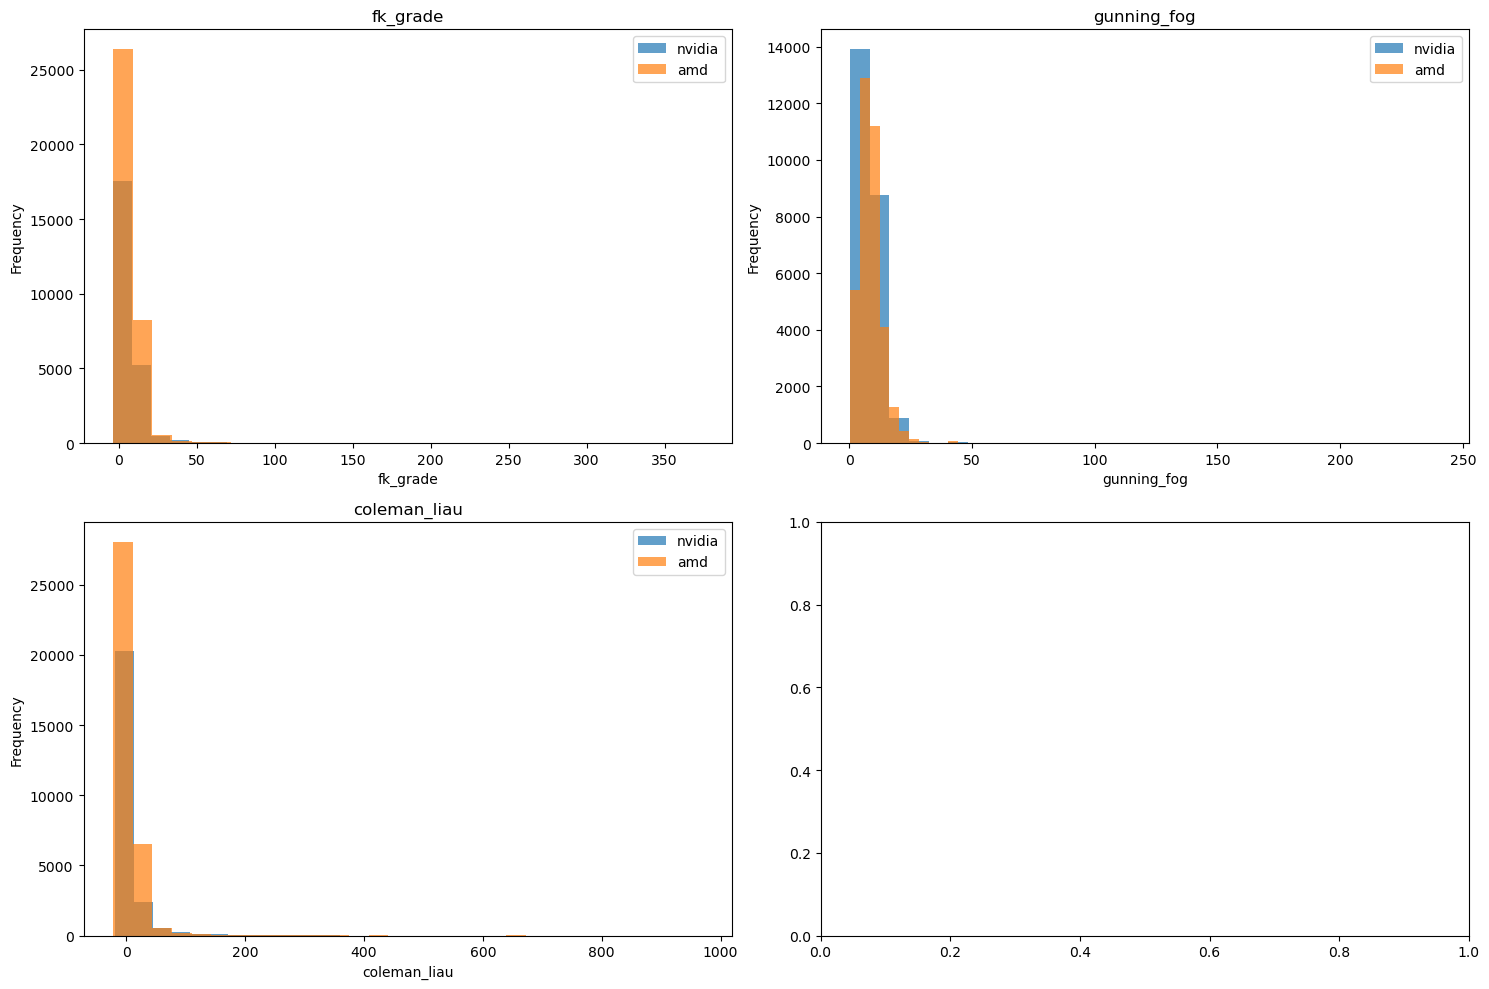

In [27]:
df_Readability_score = clean_df[['fk_grade', 'gunning_fog','coleman_liau']]   

subplot_hist(clean_df, df_Readability_score.columns, 'Subreddit', 2, 2, 30)


#### 3.3.1 Observation of readability score

- Flesch-Kincaid Grade (fk_grade): Both subreddits have a peak value around 10-12, indicating that the content is suitable for an adult audience. Amd has a slightly higher count as compare to nvidia

- Gunning Fog Index (gunning_fog): Similar to Flesch-Kincaid Grad, both peak around 10-12.

- Coleman_Liau Index (coleman_liau): Similar to Gunning Fog Index, both peak around 10-12.

So both Amd and Nvidia had roughly the same readbility score, the contents of both posts were more suitable for adult audience. 

### 3.4.0 Correlation analysis for Nvidia

Using heatmap to identify are there any correlationship between sentiment analysis, readability score, word lenght and word count?  

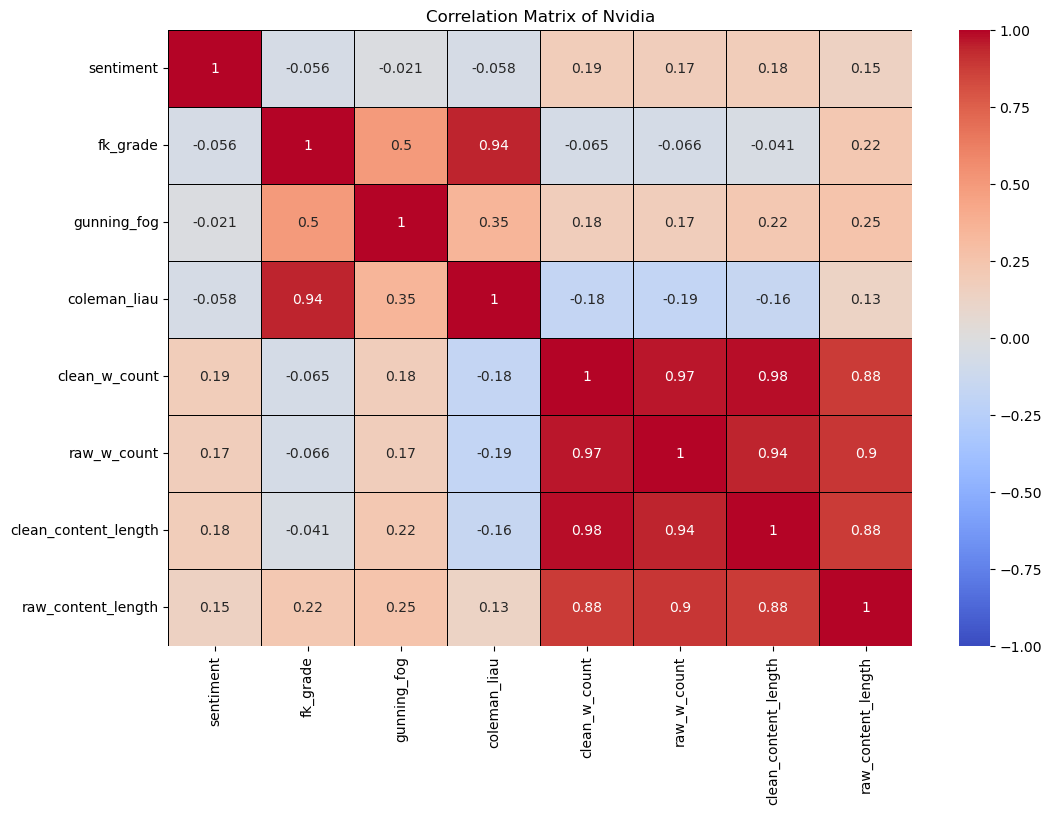

In [28]:
# Extract data from nvidia_df for correlation analysis
corr_matrix_nvidia = nvidia_df[['sentiment', 'fk_grade', 'gunning_fog', 'coleman_liau', 
                                'clean_w_count', 'raw_w_count', 'clean_content_length', 
                                'raw_content_length']].corr()


# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_nvidia, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
           linewidth=0.5, linecolor='black')

plt.title('Correlation Matrix of Nvidia')
plt.show()

#### 3.4.1 Finding for nvidia using heatmap

**Content lenght and sentiment:** There is a slight positive correlation between content length and sentiment. This suggest that the longer post might be slightly more positive, but the correlation is weak. 




#### 3.4.2 Correlation analysis for Amd

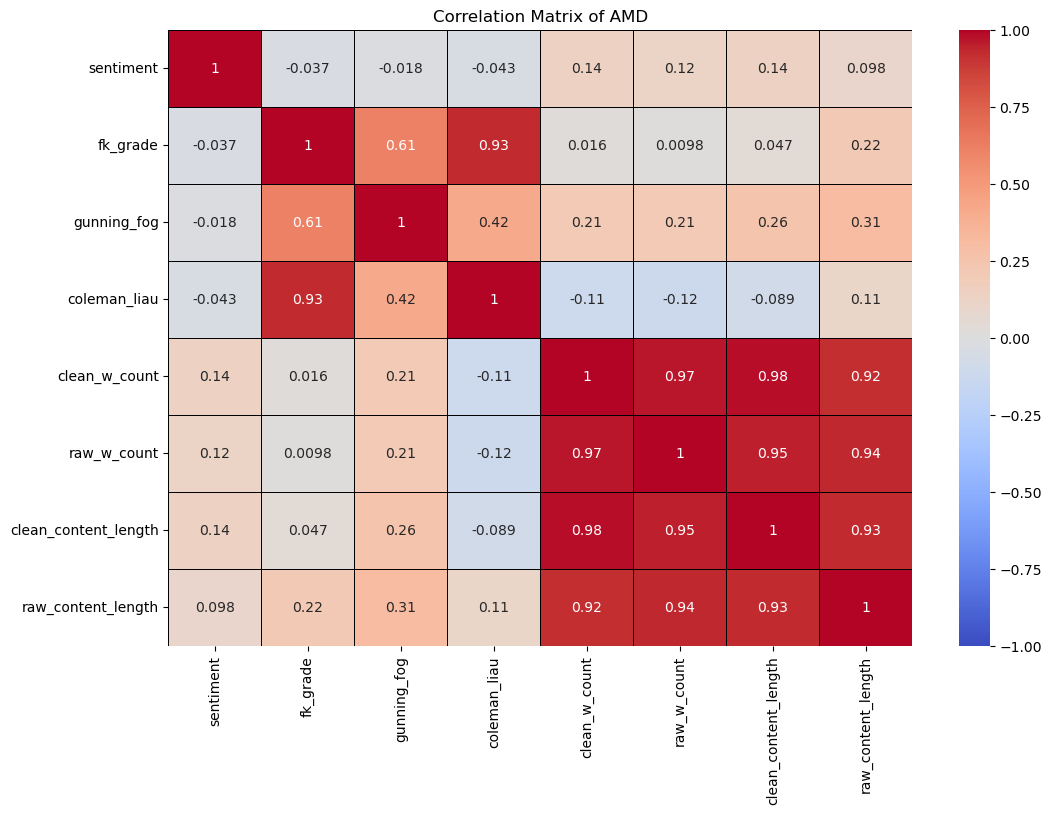

In [29]:
# Extract data from nvidia_df for correlation analysis
corr_matrix_amd = amd_df[['sentiment', 'fk_grade', 'gunning_fog', 'coleman_liau', 
                                'clean_w_count', 'raw_w_count', 'clean_content_length', 
                                'raw_content_length']].corr()


# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_amd, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
           linewidth=0.5, linecolor='black')

plt.title('Correlation Matrix of AMD')
plt.show()

#### 3.4.3 Finding for Amd using heatmap

**Content lenght and sentiment:** There is a slight positive correlation between content length and sentiment. This suggest that the longer post might be slightly more positive, but the correlation is weak. 


#### 3.4.4 Conclusion for both Amd and Nvidia using heatmap

For both Amd and Nvidia posts, they seem to share similar finding when we use heatmap to perform an analysis on them. This could conclude that both of Amd and Nvidia posts are very similar.  


### 3.5.0 Using CountVectorizer (cvec) to show the top 10 unigram bigram trigram

The content that I am going to use to feed into the CountVectorizer were non-repeated comments and non-repeated body text of each post. This content were preprocess before feeding it to the CountVectorizer, to ensure only clean text, non-repeat comments or body text would be used for this analysis.  

#### 3.5.1 Nvidia  top 10 unigram bigram trigram

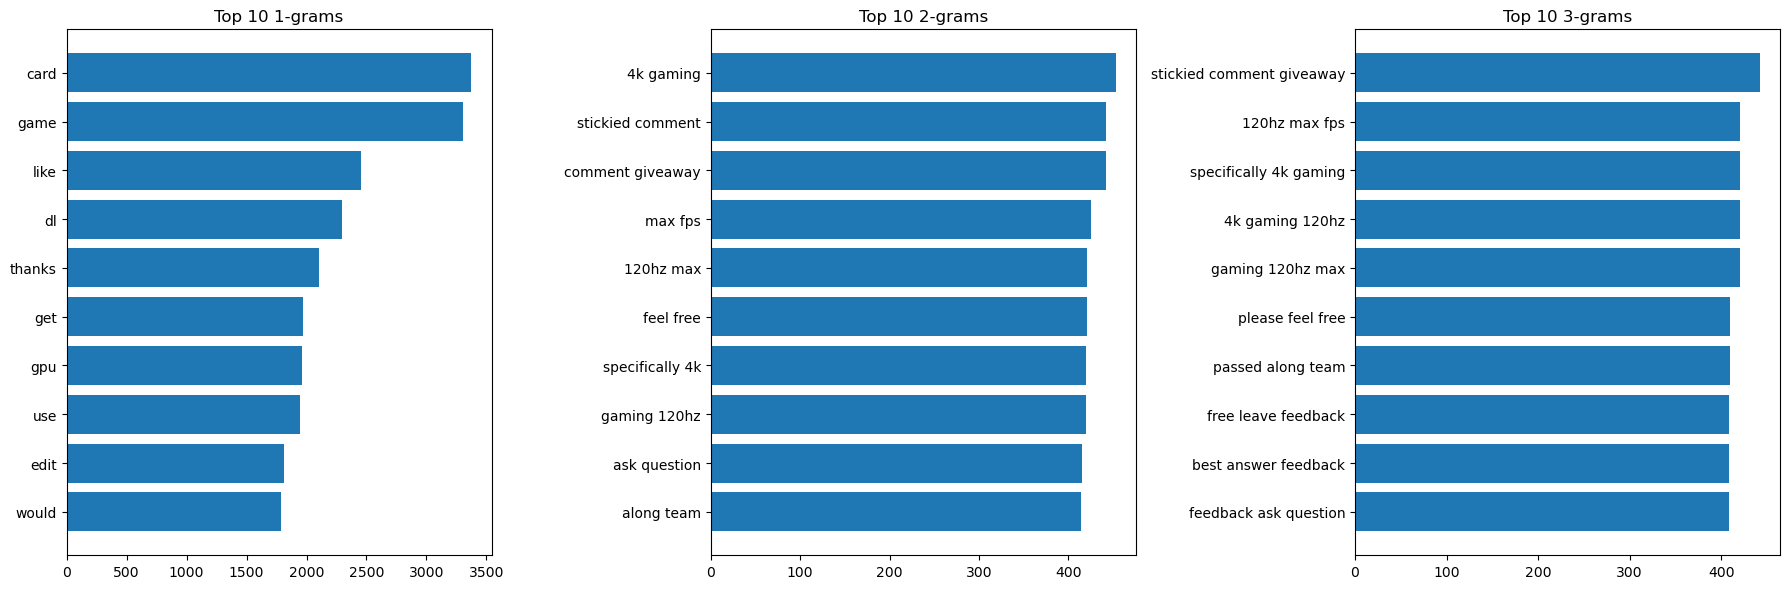

In [30]:
# Extract the clean content column and pass it to the function
filtered_df = nvidia_df['clean_content']

plt_top_ngrams_cvec(filtered_df, top_n=10)
        
    

**3.5.2Nvidia Top 10 words**

**Frequently mention words for unigrams**

- gpu: stand for Graphics processing unit, this word has been mention a lot of times in nvidia reddit forum. Since nvidia is a company that design and build graphics card, it is normal to see this word being mention a lot of times. 


**Frequently mention words for bigrams**

- 4K: means resolution or it can mean image quality of the screen 

- fps: means Frames Per Second, the higher the frame per second the higher the resolution

- 120hz: this mean that a 120hs display, which updates itself 120 times per second



#### 3.5.3 Amd  top 10 unigram bigram trigram

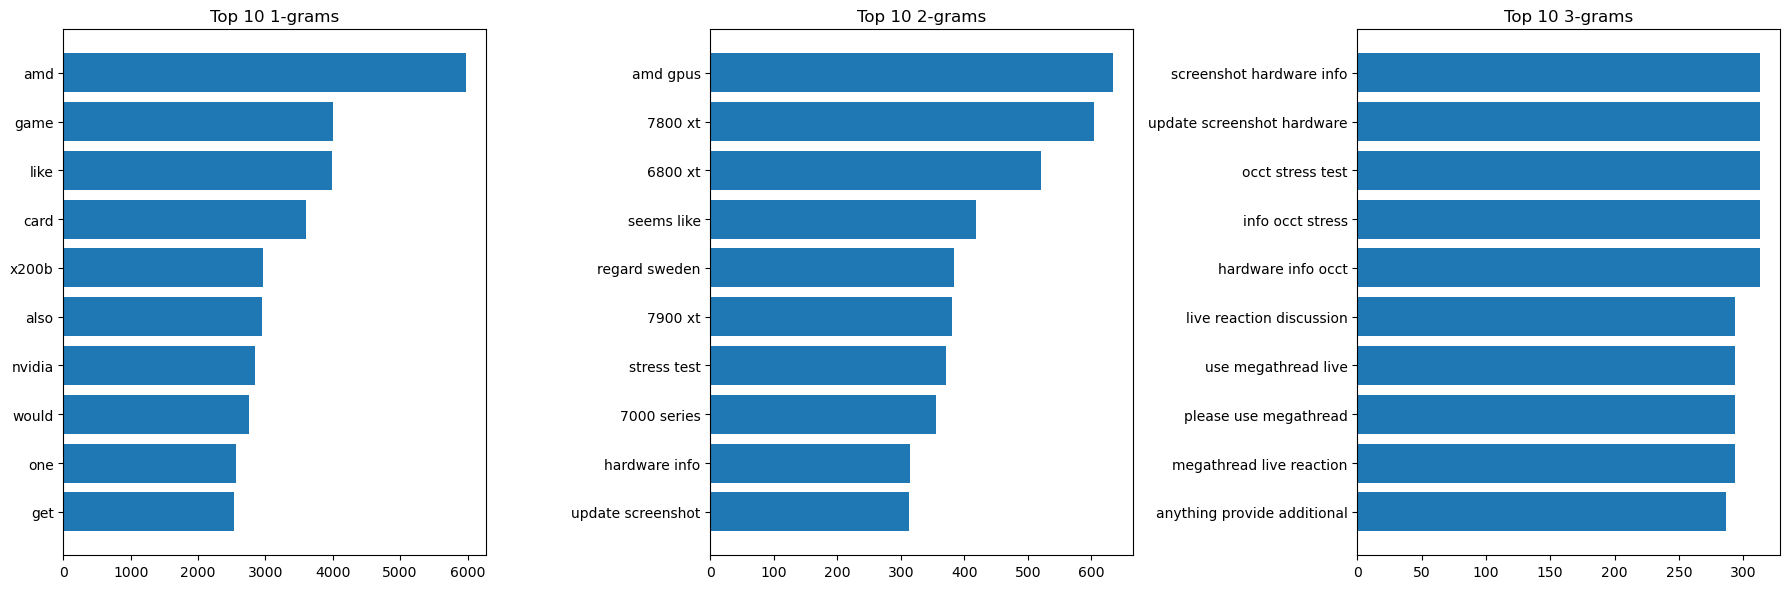

In [31]:
# Extract the clean content column and pass it to the function
filtered_df = amd_df['clean_content']

plt_top_ngrams_cvec(filtered_df, top_n=10)

**3.5.4 Amd Top 10 words**

**Frequently mention words for unigrams**

- nvidia: seem like in Amd forum, they mention about their competitor brands a lot  

**Frequently mention words for bigrams**

- 7900/6800/7800 xt: Amd graphic card.  



**3.5.5 Summary of Nvidia and Amd Top 10 common words**

**Frequently mention words for unigrams**

For unigrams out of the top 10 words, 5 words were frequently mention across in both subreddits words like "game, card, like, get, would". Nvidia subreddit only mention the word nvidia in their own subreddit, but for Amd they often mention Amd and Nvidia, it seem like they are doing some comparision. 

**Frequently mention words for bigrams**

For bigrams out of the top 10 words, non of the words they har are in common 


**Frequently mention words for trigrams**

For trigram out of the top 10 words, none of the words they had are in common 


### 3.6.0 Using TfidfVectorizer (tvec) to show the top 10 unigram bigram trigram

The content that I am going to use to feed into the TfidfVectorizer were non-repeated comments and non-repeated body text of each post. This content were preprocess before feeding it to the TfidfVectorizer, to ensure only clean text, non-repeat comments or body text would be used for this analysis. 


#### 3.6.1 Nvidia  top 10 unigram bigram trigram

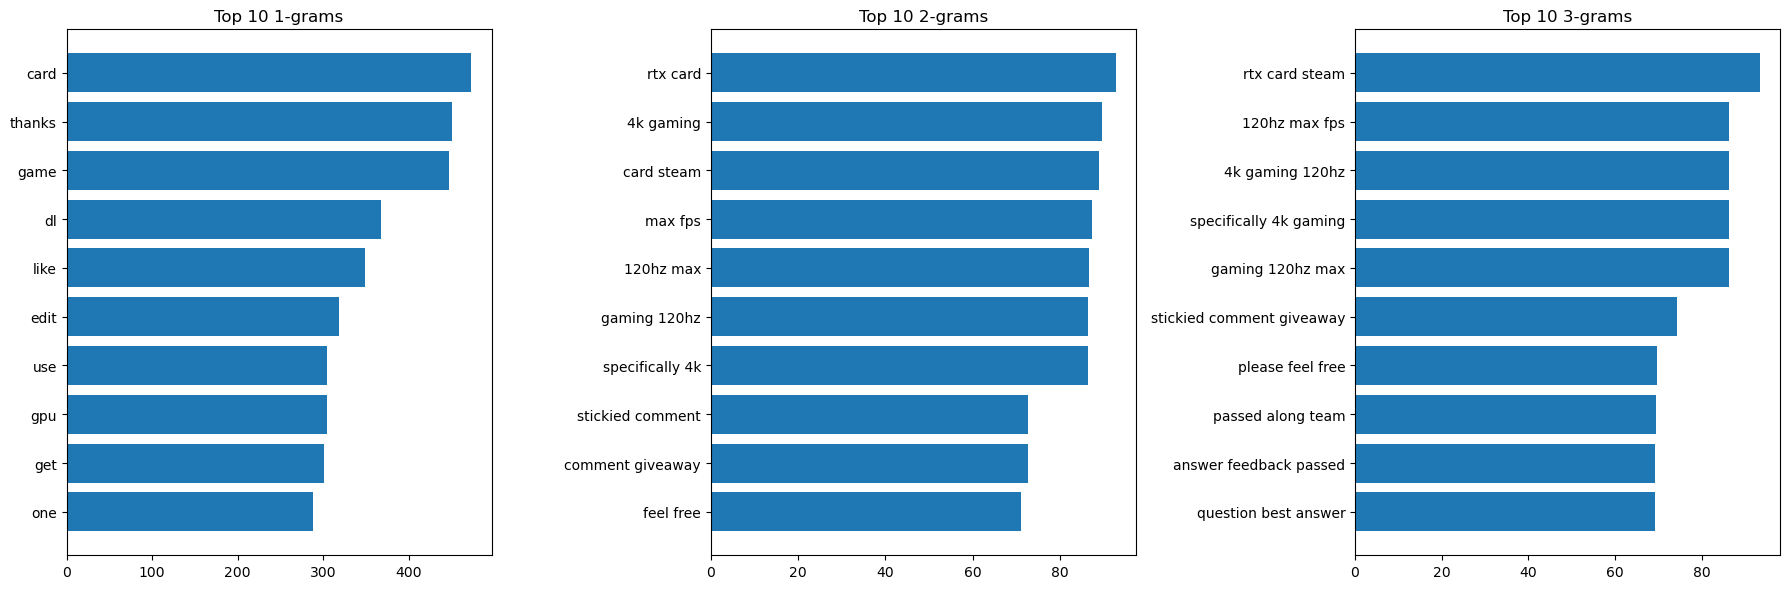

In [32]:
# Extract the clean content column and pass it to the function
filtered_df = nvidia_df['clean_content']

plt_top_ngrams_tvec(filtered_df, top_n=10)
        

**3.6.2Nvidia Top 10 words**

**Frequently mention words for unigrams**

- gpu: stand for Graphics processing unit, this word has been mention a lot of times in nvidia reddit forum. Since nvidia is a company that design and build graphics card, it is normal to see this word being mention a lot of times. 

- dl: stand for dlss or Deep Learning Super Sampling, is a new image rendering technology developed by Nvidia, which uses deep learning to produce an image that looks like a higher-resolution version of an original lower resolution image. 

- As compare both CountVectorizer and TfidfVectorizer seem to pick roughly the same words. 

**Frequently mention words for bigrams**

- rtx card: it is refering to Nvidia graphic card 

-  As compare both CountVectorizer and TfidfVectorizer seem to pick roughly the same words.  

**Frequently mention words for trigrams**

- As compare both CountVectorizer and TfidfVectorizer seem to pick roughly the same words. 

#### 3.6.3 Amd  top 10 unigram bigram trigram

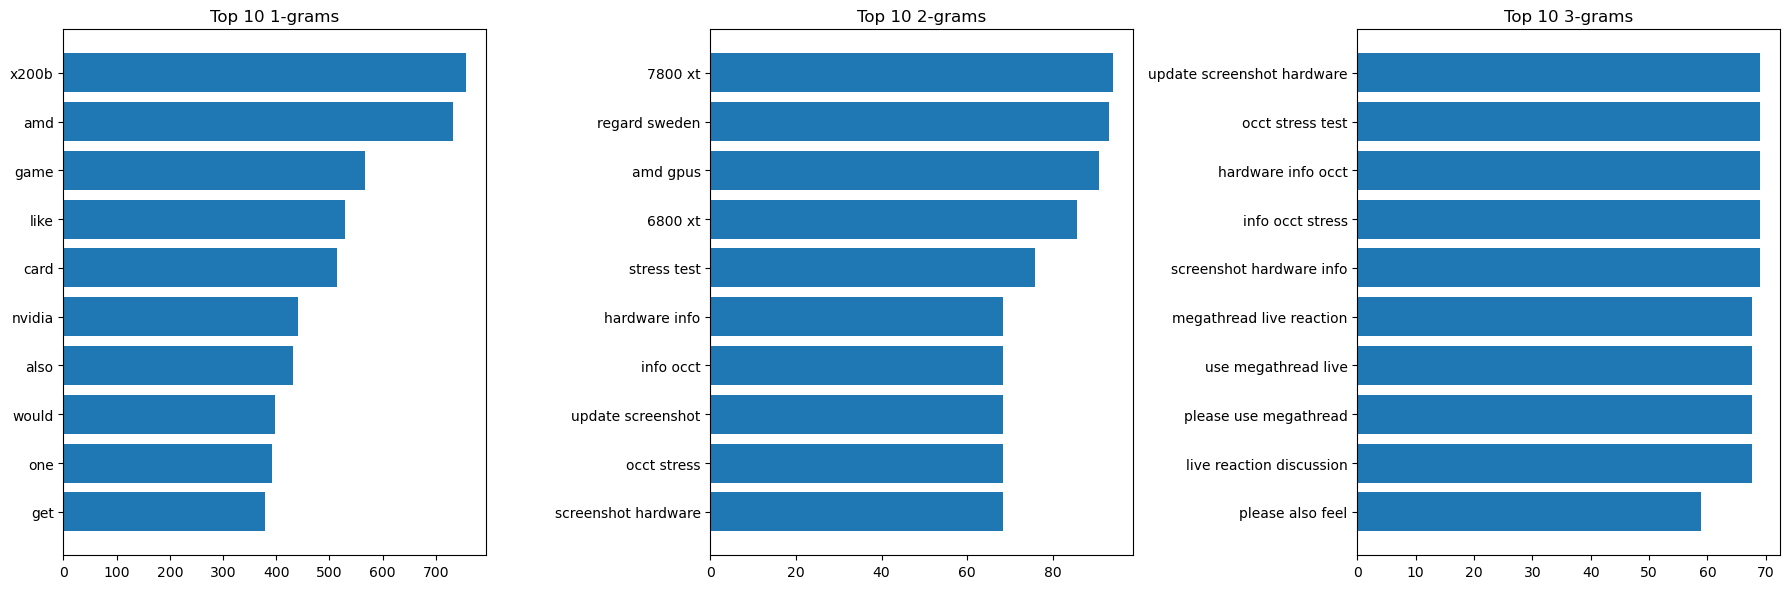

In [33]:
# Extract the clean content column and pass it to the function
filtered_df = amd_df['clean_content']

plt_top_ngrams_tvec(filtered_df, top_n=10)
        

**3.6.4 Amd Top 10 words**

**Frequently mention words for unigrams**

- nvidia: seem like in Amd forum, they mention about their competitor brands a lot  

- Nothing significant was found between CountVectorizer and TfidfVectorizer for unigrams


**Frequently mention words for bigrams**

- OCCT stress: means Over Clock Checking Tool, is a program that let's you quickly detect any error in your computer hardware.  

- Nothing significant was found between CountVectorizer and TfidfVectorizer for bigrams

**Frequently mention words for trigrams**

- As compare to CountVectorizer, TfidfVectorizer pick out one different trigram which is 'amd sponsor game'. 

**3.6.5 Summary of Nvidia and Amd Top 10 common words**

**Frequently mention words for unigrams**

For unigrams out of the top 10 words, 6 words were frequently mention across in both subreddits words like "game, card, gpu, like, well". Using tvec Amd user often mention Amd and Nvidia, it seem like they are doing some comparision. 


**Frequently mention words for bigrams**

For bigrams out of the top 10 words, 4 bigrams word were frequently mention across in both subreddits words like "go to, look like, frame gen & frame generation"


**Frequently mention words for trigrams**

For trigram out of the top 10 words, none of the words are the same between Amd and Nvidia. 

### 3.7.0 Analyzing clean_content with less than 2 word count 

#### 3.7.1 Analyzing the clean_content with 1 word count  

In [34]:
clean_df_with_1_wd = clean_df[clean_df['clean_w_count'] == 1]
clean_df_with_1_wd.head(10)

,raw_content,raw_w_count,raw_content_length,raw_avg_w_length,fk_grade,gunning_fog,coleman_liau,sentiment,num_label,clean_content,clean_w_count,clean_content_length,Subreddit
71,What is there to update then?,6,29,4.833333,0.9,2.4,1.38,0.0000,0,update,1,6,nvidia
1159,With thanks,2,13,6.500000,-3.1,0.8,-1.61,0.4404,0,thanks,1,6,nvidia
1381,"Is it worth it?""""no",4,19,4.750000,1.3,1.6,-4.36,0.2263,0,worth,1,5,nvidia
1430,"Is it worth it?""Same here",5,25,5.000000,0.5,2.0,0.32,0.2263,0,worth,1,5,nvidia
1448,4080 £1126.93 - https://www.box.co.uk/NED40800...,4,110,27.500000,36.3,1.2,146.52,0.0000,0,4080,1,4,nvidia
1530,https://preview.redd.it/6c39wy43ktmb1.jpg?widt...,2,127,63.500000,91.4,60.8,285.50,0.0000,0,boi,1,3,nvidia
1537,https://preview.redd.it/6c39wy43ktmb1.jpg?widt...,2,130,65.000000,97.3,60.8,294.20,0.0000,0,advice,1,6,nvidia
1543,https://preview.redd.it/6c39wy43ktmb1.jpg?widt...,3,134,44.666667,64.6,41.2,196.75,0.0000,0,info,1,4,nvidia
1570,https://preview.redd.it/6c39wy43ktmb1.jpg?widt...,3,129,43.000000,64.6,41.2,187.12,0.4466,0,ok,1,2,nvidia
1610,https://preview.redd.it/6c39wy43ktmb1.jpg?widt...,2,131,65.500000,91.4,60.8,291.30,0.0000,0,shout,1,5,nvidia


#### 3.7.2 Analyzing the  clean_content with 2 word count

In [35]:
clean_df_with_2_wd = clean_df[clean_df['clean_w_count'] == 2]
clean_df_with_2_wd.head(10)

,raw_content,raw_w_count,raw_content_length,raw_avg_w_length,fk_grade,gunning_fog,coleman_liau,sentiment,num_label,clean_content,clean_w_count,clean_content_length,Subreddit
236,My build so far: https://pcpartpicker.com/list...,5,58,11.600000,17.0,10.0,30.48,0.0000,0,build far,2,8,nvidia
247,My build so far: https://pcpartpicker.com/list...,5,59,11.800000,17.0,10.0,31.64,0.0000,0,build far,2,8,nvidia
249,My build so far: https://pcpartpicker.com/list...,5,62,12.400000,19.4,10.0,35.12,0.0000,0,build far,2,8,nvidia
545,So for streaming my options are:,6,32,5.333333,2.1,2.4,4.28,0.0000,0,streaming option,2,15,nvidia
570,You're ahead of me and I am not sure why,10,41,4.100000,0.1,4.0,-1.37,-0.2411,0,ahead sure,2,9,nvidia
895,Oh and I guarantee you,5,22,4.400000,2.9,10.0,-0.85,0.2500,0,oh guarantee,2,11,nvidia
932,"&#x200B;""""Thanks!",1,18,18.000000,-3.5,0.4,18.40,0.0000,0,x200b thanks,2,11,nvidia
939,"&#x200B;""""I guess",2,17,8.500000,-3.1,0.8,1.30,0.0000,0,x200b guess,2,10,nvidia
941,"3060ti or 3070""",3,15,5.000000,-2.7,1.2,-2.38,0.0000,0,3060ti 3070,2,10,nvidia
989,Yes it will bottleneck,4,22,5.500000,3.7,11.6,4.35,0.4019,0,yes bottleneck,2,13,nvidia


#### 3.7.3 After analyzing clean_content with 1 or 2 word count. 

I am going to drop all the rows that has less than 2 word count due to interpretability. Using cell that has 2 or lesser word to train the model, will lead to the model training on junk words e.g 'lol', 'work' and yep etc.   

In [36]:
clean_df_more_than_2 = clean_df[clean_df['clean_content'].apply(lambda x: len(x.split()) > 2)]

In [37]:
# dropping off columns not going to be used   
clean_df = clean_df_more_than_2.drop(columns=['Subreddit', 'raw_content', 'raw_w_count',
                                                          'raw_content_length', 'raw_avg_w_length', 'fk_grade', 'gunning_fog',
                                                          'coleman_liau', 'sentiment', 'clean_w_count',
                                                          'clean_content_length'])

In [38]:
clean_df.to_csv('clean_for_model.csv', index=False)